In [ ]:
import torch
import torch.nn as nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt

In [ ]:
# 1. Flatten 크기 자동 계산 함수
def get_flatten_size(model, input_shape=(1, 28, 28)):
    dummy = torch.zeros(1, *input_shape)
    output = model(dummy)
    return output.view(1, -1).shape[1]

In [ ]:
# 2. CNN 모델
class MNIST_CNN(nn.Module):
    def __init__(self):
        super().__init__()

        self.features = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
            nn.Conv2d(16, 32, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2),
        )

        flatten_dim = get_flatten_size(self.features, input_shape=(1, 28, 28))

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(flatten_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 10)
        )

    def forward(self, x):
        x = self.features(x)
        x = self.classifier(x)
        return x

In [ ]:
# 3. 데이터셋 준비
transform = transforms.ToTensor()
full_data = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

train_size = int(0.9 * len(full_data))
val_size = len(full_data) - train_size
train_data, val_data = random_split(full_data, [train_size, val_size])

100%|██████████| 9.91M/9.91M [00:00<00:00, 58.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.75MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 14.9MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.74MB/s]


In [ ]:
train_size, val_size

(54000, 6000)

In [ ]:
train_loader = DataLoader(train_data, batch_size=64, shuffle=True)
val_loader   = DataLoader(val_data, batch_size=64, shuffle=False)

In [ ]:
# 4. 모델, 손실함수, 옵티마이저
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MNIST_CNN().to(device)

In [ ]:
model

MNIST_CNN(
  (features): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1568, out_features=128, bias=True)
    (2): ReLU()
    (3): Linear(in_features=128, out_features=10, bias=True)
  )
)

In [ ]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 5. 학습 루프
num_epochs = 5
train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []

for epoch in range(num_epochs):
    # Train
    model.train()
    running_loss = 0.0
    correct, total = 0, 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()*labels.size(0)

        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    train_losses.append(running_loss / total)
    train_accuracies.append(100 * correct / total)

    # Validation
    model.eval()
    val_loss = 0.0
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()*labels.size(0)

            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_losses.append(val_loss / total)
    val_accuracies.append(100 * correct / total)

    print(f"Epoch {epoch+1} | Train Loss: {train_losses[-1]:.4f}, Acc: {train_accuracies[-1]:.2f}% | Val Loss: {val_losses[-1]:.4f}, Acc: {val_accuracies[-1]:.2f}%")

Epoch 1 | Train Loss: 0.2356, Acc: 92.94% | Val Loss: 0.0760, Acc: 97.65%
Epoch 2 | Train Loss: 0.0677, Acc: 98.00% | Val Loss: 0.0642, Acc: 98.05%
Epoch 3 | Train Loss: 0.0458, Acc: 98.58% | Val Loss: 0.0485, Acc: 98.33%
Epoch 4 | Train Loss: 0.0363, Acc: 98.84% | Val Loss: 0.0403, Acc: 98.63%
Epoch 5 | Train Loss: 0.0289, Acc: 99.10% | Val Loss: 0.0385, Acc: 98.73%


In [ ]:
# 6. 모델 저장
torch.save(model.state_dict(), "mnist_model.pth")
print("모델 저장 완료: mnist_model.pth")

모델 저장 완료: mnist_model.pth


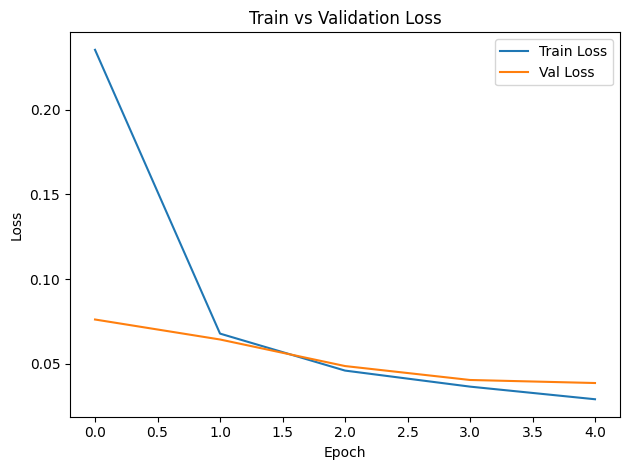

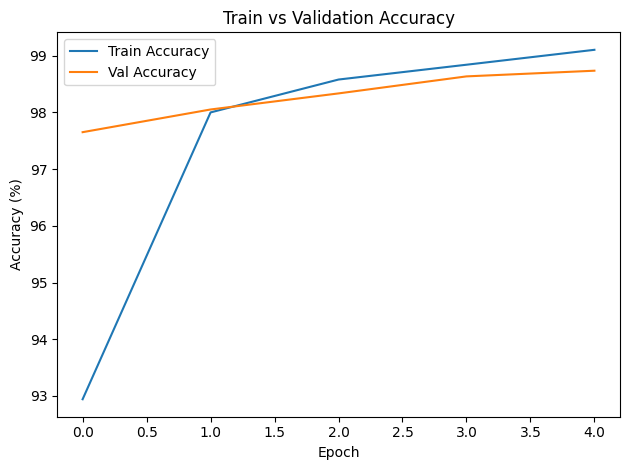

In [ ]:
# 7. 그래프 시각화

# --- Loss ---
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train vs Validation Loss")
plt.legend()
plt.tight_layout()
# plt.savefig("loss_curve.png")
plt.show()

# --- Accuracy ---
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy (%)")
plt.title("Train vs Validation Accuracy")
plt.legend()
plt.tight_layout()
plt.savefig("accuracy_curve.png")
plt.show()

In [ ]:
# Model load
import torch
from mnist_cnn import MNIST_CNN

# 디바이스 설정
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# 모델 인스턴스화
model = MNIST_CNN().to(device)

# 저장된 weight 로드
checkpoint_path = "./model/mnist_model.pth"
model.load_state_dict(torch.load(checkpoint_path, map_location=device))

# 평가모드 전환 (필수!)
model.eval()
print(model)


ModuleNotFoundError: No module named 'mnist_cnn'

In [ ]:
# 추론
from torchvision import transforms
from PIL import Image

# 전처리 함수
transform = transforms.Compose([
    transforms.Grayscale(),        # 흑백 변환 (선택적)
    transforms.Resize((28, 28)),
    transforms.ToTensor()
])

In [ ]:
from torchvision import datasets, transforms
from PIL import Image
import os

# MNIST 데이터셋 로드 (훈련셋 기준)
transform = transforms.ToTensor()
mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# 예시: 첫 번째 이미지 선택
image_tensor, label = mnist[0]  # image_tensor: (1, 28, 28), label: 정수 (0~9)

# PIL 이미지로 변환 (Tensor → PIL)
image_pil = transforms.ToPILImage()(image_tensor)

# 저장
save_path = "./test_data/sample_digit.png"
image_pil.save(save_path)

print(f"저장 완료: {save_path} (라벨: {label})")


In [ ]:
# 이미지 로딩
img = Image.open("./test_data/sample_digit.png")
img

In [ ]:
plt.imshow(img, cmap='gray')

In [ ]:
input_tensor = transform(img).unsqueeze(0).to(device)  # (1, 1, 28, 28)

In [ ]:
# 예측
with torch.no_grad():
    output = model(input_tensor)
    pred = torch.argmax(output, dim=1).item()

print(f"예측 결과: {pred}")

In [ ]:
for idx in range(10):  # 0~9까지 저장
    image_tensor, label = mnist[idx]
    image_pil = transforms.ToPILImage()(image_tensor)
    image_pil.save(f"digit_{idx}_label_{label}.png")